# Аналитика авиаперевозок

## Задача

Изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие фестивали.

## Описание данных

Таблица **airports** — информация об аэропортах:
- airport_code — трёхбуквенный код аэропорта
- airport_name — название аэропорта
- city — город
- timezone — временная зона

Таблица **aircrafts** — информация о самолётах:
- aircraft_code — код модели самолёта
- model — модель самолёта
- range — дальность перелёта

Таблица **tickets** — информация о билетах:
- ticket_no — уникальный номер билета
- passenger_id — персональный идентификатор пассажира
- passenger_name — имя и фамилия пассажира

Таблица **flights** — информация о рейсах:
- flight_id — уникальный идентификатор рейса
- departure_airport — аэропорт вылета
- departure_time — дата и время вылета
- arrival_airport — аэропорт прилёта
- arrival_time — дата и время прилёта
- aircraft_code – id самолёта

Таблица **ticket_flights** — стыковая таблица «рейсы-билеты»
- ticket_no — номер билета
- flight_id — идентификатор рейса

Таблица **festivals** — информация о фестивалях
- festival_id — уникальный номер фестиваля
- festival_date — дата проведения фестиваля
- festival_city — город проведения фестиваля
- festival_name — название фестиваля

## Схема таблиц

<img src="https://pictures.s3.yandex.net/resources/photo_2019-11-08_14-08-31_1573733426.jpg">

## Оглавление

### [Шаг 1. Парсер для сбора с сайта данных о 10 крупнейших фестивалях 2018 года](#parser)
### [Шаг 2. Исследовательский анализ данных](#exploratory_data_analysis)
### [Шаг 3.  Подготовка данных о количестве рейсов во время фестивалей](#flights_data)
### [Шаг 4. Аналитика средствами Python](#python_analysis)
### [Шаг 5. Общий вывод](#general_conclusion)

## Ход работы

#### Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

## <a id='parser'>Шаг 1. Парсер для сбора с сайта данных о 10 крупнейших фестивалях 2018 года</a>

#### Напишем парсер для сбора с сайта данных об 11 крупнейших фестивалях 2018 года. Сохраним данные в датафрейм *festivals* и выведем на экран.

In [2]:
URL = 'https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html'
req = requests.get(URL)
soup = BeautifulSoup(req.text, 'lxml')

festivals_data = []
for row in soup.find_all('td'):
    festivals_data.append(row.text)

festivals_columns = []
for row in soup.find_all('th'):
    festivals_columns.append(row.text)

name = []
place = []
date = []
for index in range(len(festivals_data)):
    if index % 3 == 0:
        name.append(festivals_data[index])
    elif index % 3 == 1:
        place.append(festivals_data[index])
    else:
        date.append(festivals_data[index])

festivals = pd.DataFrame(columns=festivals_columns)
festivals.iloc[:, 0] = name
festivals.iloc[:, 1] = place
festivals.iloc[:, 2] = date
festivals

,Название фестиваля,Место проведения,Дата проведения
0,Музыкальный фестиваль «Усадьба Jazz»,Екатеринбург,01.07.2018
1,Фестиваль музыки и технологий Alfa Future People,Нижний Новгород,10.08.2018
2,"Фестиваль еды «О, да! Еда!»",Санкт-Петербург,21.07.2018
3,Доброфест,Ярославль,29.07.2018
4,Park Live,Москва,28.07.2018
5,Пикник Афиши,Москва,04.08.2018
6,VK FEST,Санкт-Петербург,29.07.2018
7,"Фестиваль «О, да! Еда!»",Иркутск,25.08.2018
8,"Фестиваль «О, да! Еда!»",Владивосток,02.09.2018
9,Видфест,Москва,08.09.2018


## Внимание! Шаги 2 и 3 выполнялись в тренажёре сервиса Яндекс.Практикум. В Jupyter Notebook представлено лишь их оформление.

## <a id='exploratory_data_analysis'>Шаг 2. Исследовательский анализ данных</a>

#### Найдём количество рейсов с вылетом в сентябре 2018 года на каждой модели самолёта. Назовём получившееся поле *flights_amount* и выведем его, а также поле *model*.

`select model
  , count(flight_id) as flights_amount
from aircrafts ac
  join flights f
    on ac.aircraft_code = f.aircraft_code
where 1 = 1
  and f.departure_time::date between '2018-09-01' and '2018-09-30'
group by model
;`

#### Посчитаем количество рейсов по всем моделям самолетов *Boeing* и *Airbus* в сентябре. Назовём получившуюся переменную *flights_amount* и выведем её.

`select count(flight_id) as flights_amount
  , case
      when model like 'Airbus%' then 'Airbus'
      when model like 'Boeing%' then 'Boeing'
      else 'other'
      end as type_aircraft
from aircrafts ac
  join flights f
    on ac.aircraft_code = f.aircraft_code
where 1 = 1
  and f.departure_time::date between '2018-09-01' and '2018-09-30'
group by type_aircraft
;`

#### Посчитаем среднее количество прибывающих рейсов в день для каждого города за август 2018 года. Назовём получившееся поле *average_flights* , вместе с ним выведем столбец *city*.

`select city
  , count(flight_id)::numeric / count(distinct arrival_time::date) as average_flights
from airports ap
  join flights f
    on ap.airport_code = f.arrival_airport
where 1 = 1
  and f.arrival_time::date between '2018-08-01' and '2018-08-31'
group by city
;`

## <a id='flights_data'>Шаг 3.  Подготовка данных о количестве рейсов во время фестивалей</a>

#### Установим фестивали, которые проходили с 23 июля по 30 сентября 2018 года в Москве, и номер недели, в которую они проходили. Выведем название фестиваля *festival_name* и номер недели *festival_week*.

`select festival_name
  , extract(week from festival_date::date) as festival_week
from festivals
where 1 = 1
  and festival_date::date between '2018-07-23' and '2018-09-30'
  and festival_city = 'Москва'
;`

#### Для каждой недели с 23 июля по 30 сентября 2018 года посчитаем количество билетов, купленных на рейсы в Москву (номер недели *week_number* и количество рейсов *flights_amount*). Получим таблицу, в которой будет информация о количестве купленных за неделю билетов, отметка, проходил ли в эту неделю фестиваль, название фестиваля *festival_name* и номер недели *week_number*.

`with
subq as (
    select festival_name
      , extract(week from festival_date::date) as festival_week
    from festivals
    where 1 = 1
      and festival_date::date between '2018-07-23' and '2018-09-30'
      and festival_city = 'Москва'
)
, subq2 as (
    select extract(week from f.arrival_time::date) as week_number
      , count(tf.ticket_no) as ticket_amount
    from flights f
      join ticket_flights tf
        on f.flight_id = tf.flight_id
      join airports ap
        on f.arrival_airport = ap.airport_code
    where 1 = 1
      and f.arrival_time::date between '2018-07-23' and '2018-09-30'
      and ap.city = 'Москва'
    group by extract(week from f.arrival_time::date)
)
select *
from subq2
  left join subq
    on subq2.week_number = subq.festival_week
;`

Таблица получилась совсем небольшой: проверять по ней гипотезу о связи музыкальных фестивалей и спроса на авиабилеты некорректно. Можно предположить, что во время фестивалей спрос практически не меняется: значения в столбце с количеством билетов в недели фестиваля никак не выделяются.

## <a id='python_analysis'>Шаг 4. Аналитика средствами Python</a>

Имеются файлы, в которых содержатся результаты запросов из предыдущих шагов.

**/datasets/query_1.csv** — результат первого запроса. В нём содержится информация о:
- model — модели самолета
- flights_amount — количество рейсов для каждой модели самолетов model в сентябре 2018 года

**/datasets/query_3.csv** — результат третьего запроса. В нём содержится информация о:
- city — городах
- average_flights — среднем количестве рейсов, прибывающих в город city за день в августе 2018 года

In [3]:
def review_file(filename, title):
    '''
    Функция сохраняет данные в возвращаемую переменную
    и выводит необходимую информацию на экран.
    
    Аргументы:
        filename (str): путь к файлу.
        
        title (str): название таблицы.
    '''
    
    table = pd.read_csv(filename)
    
    print(f'Общая информация о таблице {title}:')
    print()
    table.info()
    print()
    
    n = table.shape[0]
    if n < 10:
        print(f'Таблица {title}:')
        display(table)
    else:
        print(f'Первые 10 строк таблицы {title}:')
        display(table.head(10))
        
    print(f'Количество пропусков в каждом столбце таблицы {title}:')
    display(pd.DataFrame(table.isna().sum()))
    
    print(f'Число дубликатов в таблице {title}: {table.duplicated().sum()}')
    
    return table

#### Откроем файлы с данными и изучим их.

In [4]:
model_flights = review_file('/datasets/query_1.csv', 'model_flights')

Общая информация о таблице model_flights:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes

Таблица model_flights:


,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


Количество пропусков в каждом столбце таблицы model_flights:


,0
model,0
flights_amount,0


Число дубликатов в таблице model_flights: 0


In [5]:
city_flights = review_file('/datasets/query_3.csv', 'city_flights')

Общая информация о таблице city_flights:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB

Первые 10 строк таблицы city_flights:


,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
5,Барнаул,2.612903
6,Белгород,6.000000
7,Белоярский,2.000000
8,Благовещенск,1.000000
9,Братск,1.000000


Количество пропусков в каждом столбце таблицы city_flights:


,0
city,0
average_flights,0


Число дубликатов в таблице city_flights: 0


In [6]:
def draw_bar(data, x, y, title, xlabel, ylabel, fontsize=18, 
             labelsize=18, orient='v', valuelabelformat='%.0f'):
    '''
    Функция выводит график столбчатой диаграммы с
    заданными параметрами.
    
    Аргументы:
        x (str): название столбца, отображаемого по абсциссе.
        
        y (str): название столбца, отображаемого по ординате.
        
        data (pandas.core.frame.DataFrame): таблица с данными.
        
        orient (str): вертикальная диаграмма ('v') или горизонатльная ('h').
        
        title (str): заголовок диаграммы.
        
        xlabel (str): подпись оси абсцисс.
        
        ylabel (str): подпись оси ординат.
        
        fontsize (int): размер шрифта.
        
        labelsize (int): размер меток.
        
        valuelabelformat (str): формат меток значений.
    '''
    
    if data.shape[0] > 10:
        n = 40
    else:
        n = 12
        
    plt.figure(figsize=(20, n))
    ax = sns.barplot(
        x=x, 
        y=y, 
        data=data, 
        orient=orient,
        color='royalblue'
    )

    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    if orient == 'v':
        for rect in ax.patches:
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_height(),
                valuelabelformat % rect.get_height(),
                fontsize=fontsize,
                ha='center'
            )
    else:
        for rect in ax.patches:
            ax.text(
                rect.get_width(), 
                rect.get_y() + rect.get_height() / 2, 
                valuelabelformat % rect.get_width(),
                fontsize=fontsize,
                va='center'
            )
    plt.show()

#### Посмотрим, полёты на каких самолётах были самими популярными в сентябре 2018 года.

In [7]:
top_models = (
    model_flights
    .groupby('model', as_index=False)
    .agg({'flights_amount': 'mean'})
    .sort_values(by='flights_amount', ascending=False)
)

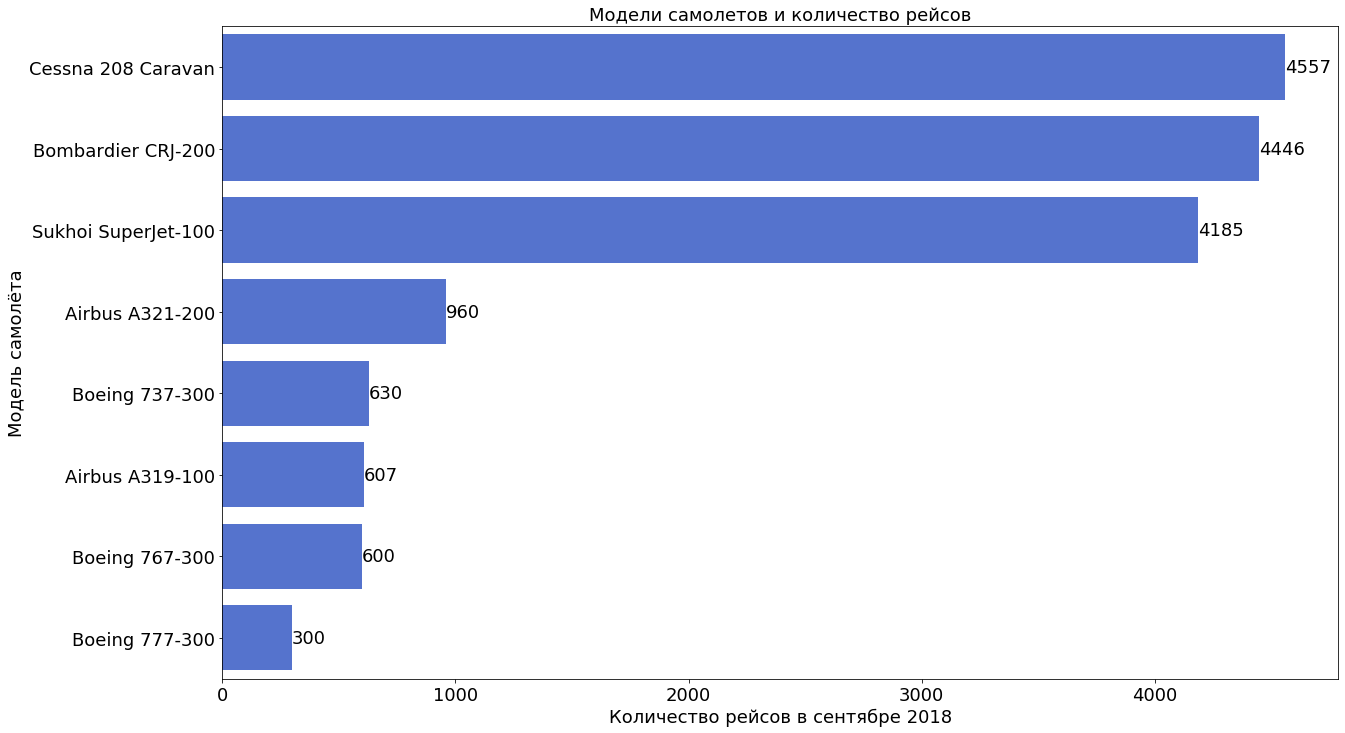

In [8]:
draw_bar(
    data=top_models,
    x='flights_amount', 
    y='model', 
    title='Модели самолетов и количество рейсов', 
    xlabel='Количество рейсов в сентябре 2018', 
    ylabel='Модель самолёта', 
    orient='h'
)

Самолёты моделей *Cessna 208 Caravan*, *Bombardier CRJ-200* и *Sukhoi Superjet-100* были в разы популярнее остальных моделей в сентябре 2018 года. Каждая модель совершила свыше 4100 рейсов, тогда как самолёты остальных моделей не совершили и 1000. 

Стоит отметить, что самолёт *Cessna 208 Caravan*, совершивший больше всего рейсов, перевозит лишь 9 пассажиров. Обычно такие самолёты летают на коротки расстояния. Следовательно, такой самолёт может осуществлять несколько рейсов ежедневно.

В Сибири авиаперевозки являются очень важным элементом транспортной системы из-за сложного ландшафта и плохих дорог. В частности, самолёты *Cessna 208 Caravan* активно используются не только как пассажирские, но и как грузовые самолёты. Из-за своей надёжности их часто используют на севере.

#### Посмотрим, в какие города летали чаще всего в августе 2018 года.

In [9]:
top_cities = (
    city_flights
    .groupby('city', as_index=False)
    .agg({'average_flights': 'mean'})
    .sort_values(by='average_flights', ascending=False)
)

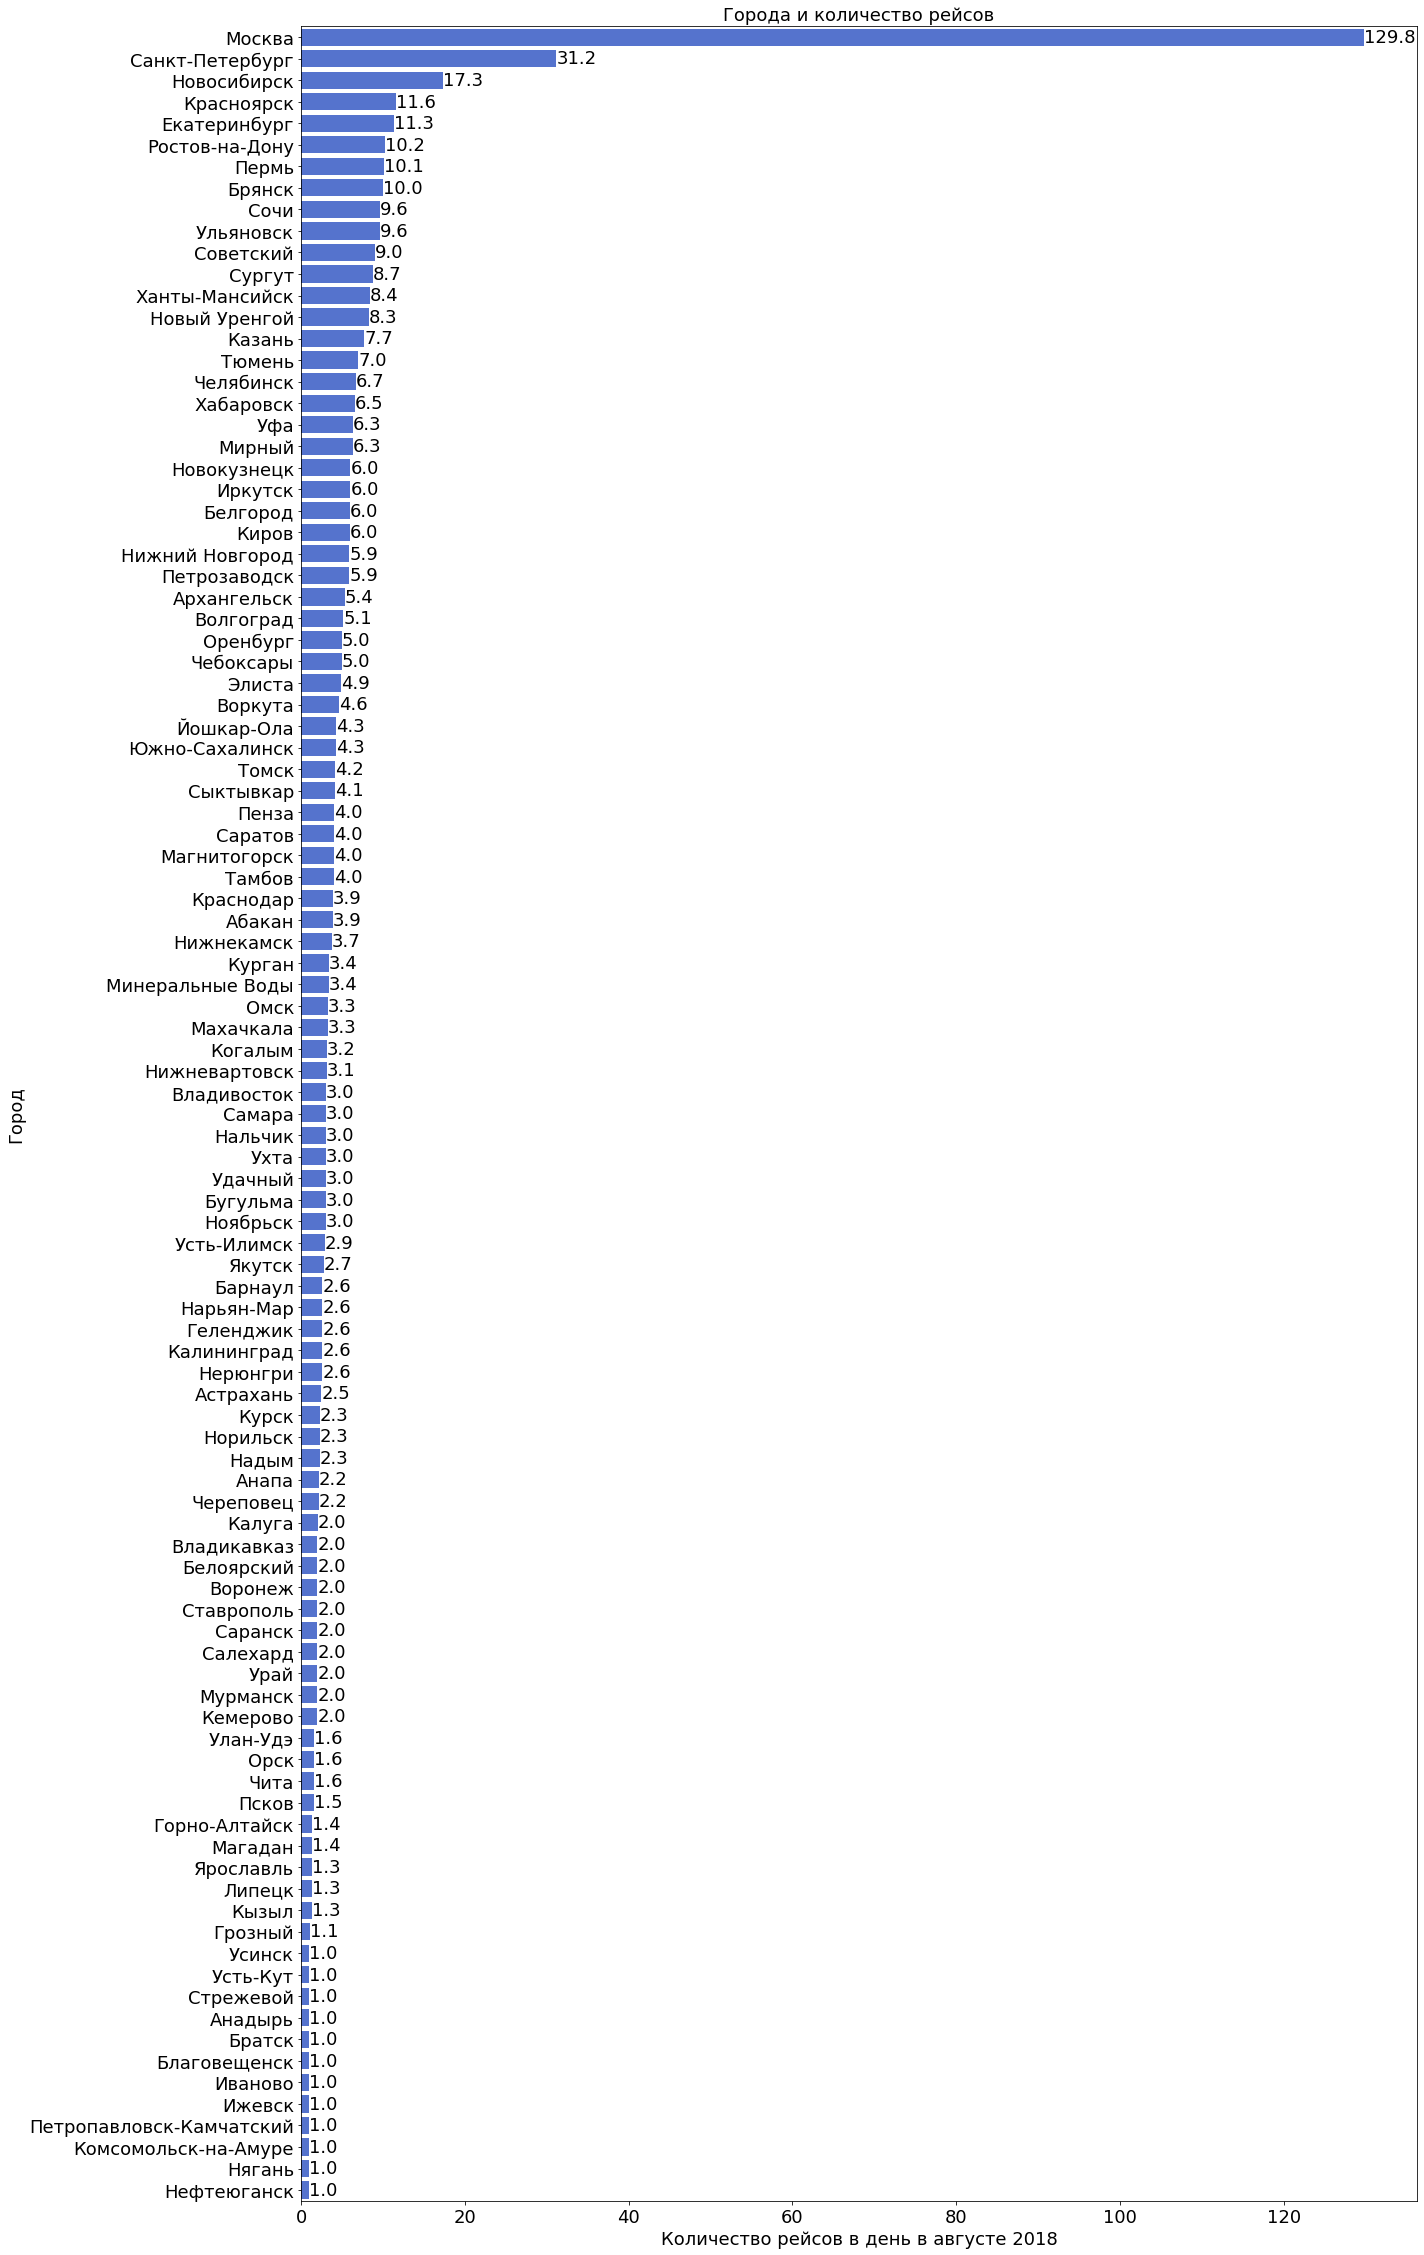

In [10]:
draw_bar(
    data=top_cities,
    x='average_flights', 
    y='city', 
    title='Города и количество рейсов', 
    xlabel='Количество рейсов в день в августе 2018', 
    ylabel='Город', 
    orient='h',
    valuelabelformat='%.1f'
)

Среднее количество рейсов, прибывающих в Москву за день в августе 2018 года — 130, тогда как в идущий на втором месте Санкт-Петербург прибывал в среднем лишь 31 рейс. На третьем месте расположился Новосибирск, уступающий северной столице чуть менее чем в 2 раза. Разрывы между числом рейсов в остальные города не столь грандиозны. Распределение рейсов выглядит логично: в крупные экономические центры летают чаще, чем в маленькие отдалённые городки.

#### Выберем топ-10 городов по числу рейсов и рассмотрим их отдельно.

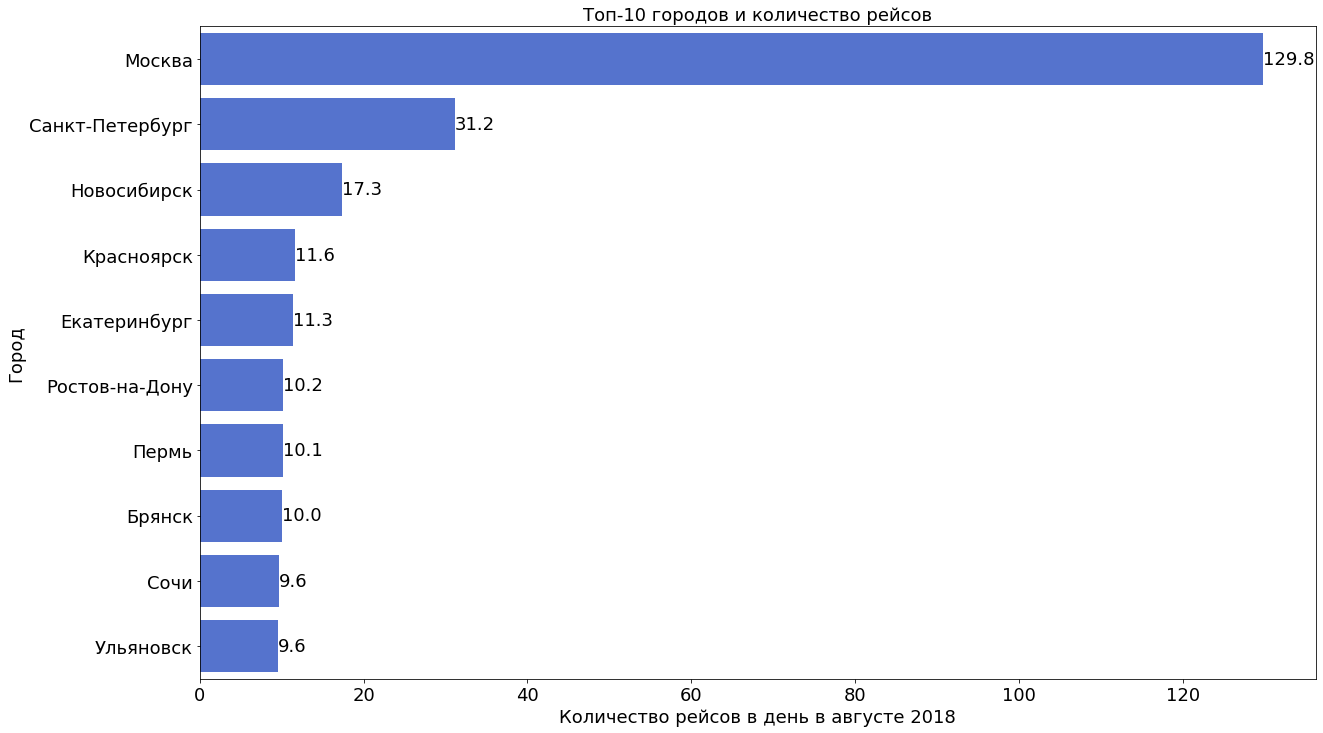

In [11]:
draw_bar(
    data=top_cities.head(10),
    x='average_flights', 
    y='city', 
    title='Топ-10 городов и количество рейсов', 
    xlabel='Количество рейсов в день в августе 2018', 
    ylabel='Город', 
    orient='h',
    valuelabelformat='%.1f'
)

Лидерство Москвы, Санкт-Петербурга и Новосибирска никак не связано с фестивалями непосредственно в этих городах. В Москве в августе проходил всего один крупный фестиваль, да и то в начале месяца. В Петербуге и Новосибирске же фестивалей в августе не было вообще. С другой стороны, все три города, помимо своей значимой социально-экономической роли, также являются крупными транзитными пунктами, а значит рейсы в другие города зачастую осуществляются с пересадкой в них.

Также стоит отметить, что фестиваль «О, да! Еда!» проходил в конце августа и начале сентября в Иркутске и Владивостоке соответственно. Рейсов непосредственно в эти города оказалось не так много, однако данный факт может оказать влияние на популярность относительно недалёкого от Иркутска Красноярска (в частности, перевозку туристических групп между этими городами вполне мог осуществлять популярный *Cessna 208 Caravan*), а также ещё большей популярности Новосибирска, через который часто добираются до Владивостока.

Популярность Сочи, несомненно, связана с временем сбора данных. На август зачастую приходится большинство отпусков и люди едут отдохнуть в курортный городок.

### Вывод

Датафрейм *model_flights* состоит из 8 строк и 2 столбцов. 
Датафрейм *city_flights* состоит из 101 строки и 2 столбцов.
Пропуски и дубликаты отсутствуют. Типы данных корректны.

Самолёты моделей *Cessna 208 Caravan*, *Bombardier CRJ-200* и *Sukhoi Superjet-100* были в разы популярнее остальных моделей в сентябре 2018 года. Каждая модель совершила свыше 4100 рейсов, тогда как самолёты остальных моделей не совершили и 1000. 

Стоит отметить, что самолёт *Cessna 208 Caravan*, совершивший больше всего рейсов, перевозит лишь 9 пассажиров. Обычно такие самолёты летают на коротки расстояния. Следовательно, такой самолёт может осуществлять несколько рейсов ежедневно.

В Сибири авиаперевозки являются очень важным элементом транспортной системы из-за сложного ландшафта и плохих дорог. В частности, самолёты *Cessna 208 Caravan* активно используются не только как пассажирские, но и как грузовые самолёты. Из-за своей надёжности их часто используют на севере.

Среднее количество рейсов, прибывающих в Москву за день в августе 2018 года — 130, тогда как в идущий на втором месте Санкт-Петербург прибывал в среднем лишь 31 рейс. На третьем месте расположился Новосибирск, уступающий северной столице чуть менее чем в 2 раза. Разрывы между числом рейсов в остальные города не столь грандиозны. Распределение рейсов выглядит логично: в крупные экономические центры летают чаще, чем в маленькие отдалённые городки.

Лидерство Москвы, Санкт-Петербурга и Новосибирска никак не связано с фестивалями непосредственно в этих городах. В Москве в августе проходил всего один крупный фестиваль, да и то в начале месяца. В Петербуге и Новосибирске же фестивалей в августе не было вообще. С другой стороны, все три города, помимо своей значимой социально-экономической роли, также являются крупными транзитными пунктами, а значит рейсы в другие города зачастую осуществляются с пересадкой в них.

Также стоит отметить, что фестиваль «О, да! Еда!» проходил в конце августа и начале сентября в Иркутске и Владивостоке соответственно. Рейсов непосредственно в эти города оказалось не так много, однако данный факт может оказать влияние на популярность относительно недалёкого от Иркутска Красноярска (в частности, перевозку туристических групп между этими городами вполне мог осуществлять популярный *Cessna 208 Caravan*), а также ещё большей популярности Новосибирска, через который часто добираются до Владивостока.

Популярность Сочи, несомненно, связана с временем сбора данных. На август зачастую приходится большинство отпусков и люди едут отдохнуть в курортный городок.

Таким образом, проведение фестиваля в том или ином городе не сильно повышает спрос пассажиров на рейсы в города, где они проходят, однако могут повысить спрос на рейсы в крупные экономически центры, а также повлиять на популярность самолётов, осуществляющих короткие перевозки.

## <a id='general_conclusion'>Шаг 5. Общий вывод</a>

Написан парсер для сбора с <a href='https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html'>сайта</a> данных об 11 крупнейших фестивалях 2018 года. 

- Запрос 1: Найдено количество рейсов на каждой модели самолёта с вылетом в сентябре 2018 года.
- Запрос 2: Посчитано количество рейсов по всем моделям самолётов Boeing, Airbus и другим в сентябре.
- Запрос 3: Посчитано среднее количество прибывающих рейсов в день для каждого города за август 2018 года.
- Запрос 4: Установлены фестивали, которые проходили с 23 июля по 30 сентября 2018 года в Москве, и номер недели, в которую они проходили.
- Запрос 5: Для каждой недели с 23 июля по 30 сентября 2018 года посчитано количество билетов, купленных на рейсы в Москву. Получена таблица, в которой находится информация о количестве купленных за неделю билетов; отметка, проходил ли в эту неделю фестиваль; название фестиваля и номер недели. Таблица получилась совсем небольшой: проверять по ней гипотезу о связи музыкальных фестивалей и спроса на авиабилеты некорректно. Можно предположить, что во время фестивалей спрос практически не меняется: значения в столбце с количеством билетов в недели фестиваля никак не выделяются.

Работа была продолжена с таблицами формата *csv*, содержащими результаты запросов 1 и 3. Данные были считаны в переменные *model_flights* и *city_flights* соответственно. 

Датафрейм *model_flights* состоит из 8 строк и 2 столбцов. 
Датафрейм *city_flights* состоит из 101 строки и 2 столбцов.
Пропуски и дубликаты отсутствуют. Типы данных корректны.

Самолёты моделей *Cessna 208 Caravan*, *Bombardier CRJ-200* и *Sukhoi Superjet-100* были в разы популярнее остальных моделей в сентябре 2018 года. Каждая модель совершила свыше 4100 рейсов, тогда как самолёты остальных моделей не совершили и 1000. 

Стоит отметить, что самолёт *Cessna 208 Caravan*, совершивший больше всего рейсов, перевозит лишь 9 пассажиров. Обычно такие самолёты летают на коротки расстояния. Следовательно, такой самолёт может осуществлять несколько рейсов ежедневно.

В Сибири авиаперевозки являются очень важным элементом транспортной системы из-за сложного ландшафта и плохих дорог. В частности, самолёты *Cessna 208 Caravan* активно используются не только как пассажирские, но и как грузовые самолёты. Из-за своей надёжности их часто используют на севере.

Среднее количество рейсов, прибывающих в Москву за день в августе 2018 года — 130, тогда как в идущий на втором месте Санкт-Петербург прибывал в среднем лишь 31 рейс. На третьем месте расположился Новосибирск, уступающий северной столице чуть менее чем в 2 раза. Разрывы между числом рейсов в остальные города не столь грандиозны. Распределение рейсов выглядит логично: в крупные экономические центры летают чаще, чем в маленькие отдалённые городки.

Лидерство Москвы, Санкт-Петербурга и Новосибирска никак не связано с фестивалями непосредственно в этих городах. В Москве в августе проходил всего один крупный фестиваль, да и то в начале месяца. В Петербуге и Новосибирске же фестивалей в августе не было вообще. С другой стороны, все три города, помимо своей значимой социально-экономической роли, также являются крупными транзитными пунктами, а значит рейсы в другие города зачастую осуществляются с пересадкой в них.

Также стоит отметить, что фестиваль «О, да! Еда!» проходил в конце августа и начале сентября в Иркутске и Владивостоке соответственно. Рейсов непосредственно в эти города оказалось не так много, однако данный факт может оказать влияние на популярность относительно недалёкого от Иркутска Красноярска (в частности, перевозку туристических групп между этими городами вполне мог осуществлять популярный *Cessna 208 Caravan*), а также ещё большей популярности Новосибирска, через который часто добираются до Владивостока.

Популярность Сочи, несомненно, связана с временем сбора данных. На август зачастую приходится большинство отпусков и люди едут отдохнуть в курортный городок.

Таким образом, проведение фестиваля в том или ином городе не сильно повышает спрос пассажиров на рейсы в города, где они проходят, однако могут повысить спрос на рейсы в крупные экономически центры, а также повлиять на популярность самолётов, осуществляющих короткие перевозки.